# Dimensionality Reduction 

When we have a dataset with a large number of variables we need to ask questions like:

* Are all of the variables important
* How can I identify the signficant varaibles
* Faced will all of these variables will my algorithm run to slow?

Thankfully dimensionality reduction can help use here. Dimensionality reductions is the process of converting a set of data with many dimensions into data with less dimensions, it has two main use cases.

* Helping to visualize higher dimensional features
* Reducing the number of features in the dataset, so we can train model quicker/better.


# Feature Selection

The simplest form of dimensionality reduction would be feature selection, by only choosing to use say 3 features out of 10, we've reduced the dimensionality from 10D to 3D. Feature selection has a number of benefits inclduing:

* Short training times
* Avoiding the curse of dimensionality (covered further down)
* Helping to reduce overfitting

Imagine we had a variable with really low variance in the dataset ,say it's value is 3 for every observation. Does this variable add predictive power to the model? No because it's exactly same across all of the examples  What about if two variables are highly correlated. In such case feeding highly correlated varaibles to the model,  can confuse it since both contain similar information, it's almost like feeding the model duplicated information. We can use pearson correlation coeffient to check if the variables are correlated.  Plotting the correlation matrix as an heat map can be a easiy way to do this.  The above idea are almost like manual ways of performing dimensionality reduction however there are more stastical approaches such as factor analysis, explained bellow.



# PCA

Dimensionality reduction is useful for two reason:

* It makes it easier to view higher dimensional data
* Can reduce computational cost of running learning algorithms.

PCA or principal compenent analysis, is a dimensionality reduction technqiue that allows us to more easily visulize higher dimensional data. This is achieved by applying a linear transform to the data, we'll cover more on linear transformation later. For now think of it as rotating it so we can view it from the best angle.  The way PCA finds the new axis for the rotation is by looking for the directions of maximum variance.

# Algorithm

* Standadize the data
* Calculate eigen values
* Transform the original $ X $ data set using $ W $ to comain a new $ k $ dimensional feature subspace $ Y $
* Sort the eigen values in descending order and choose $ k $ eigen vectors that correspond to the $ k $ largest eigen vecots
* Construct the projection matrix W from the $ k $ eigen vectors

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
df = sns.load_dataset('iris')
X = df.iloc[:,:4].values
y =df.iloc[:,4].values
X.shape #150 examples, each example has 4 features

(150, 4)

 $$ \mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix} $$

# Standardization

We need to standardize the data before we can calculate the eigen values, this can be achieved by subtracting the mean and dividng by standard deviation. This rescales the data to have a mean $ \mu $ of 0 and a standard deviation $ \sigma $ or 1 (unit of variance).

$$ {\frac {X-\mu }{\sigma }} $$

In [3]:
mu = X.mean(axis=0)
sigma = X.std(axis=0).mean()
X= (X - mu) / sigma

# Eigenvectors and Eigenvalues

We can obtain the eigen vectors and values through various approaches,such as eigendecomposition of the covariance matrix or SVD (singular value decomposition) However in practice most implementations use SVD (singular value decomposition) since it's the least computationally expensive, so well use that. We'll get onto what the eigenvectors and values mean later

In [4]:
eigenvectors, eigenvalues, _ = np.linalg.svd(X.T, full_matrices=False)

In [5]:
print(eigenvectors)

[[-0.36138659 -0.65658877  0.58202985  0.31548719]
 [ 0.08452251 -0.73016143 -0.59791083 -0.3197231 ]
 [-0.85667061  0.17337266 -0.07623608 -0.47983899]
 [-0.3582892   0.07548102 -0.54583143  0.75365743]]


In [6]:
print(eigenvalues)

[26.56917643  6.36512452  3.61349905  1.99483333]


# Transform data

Now that we've calculated the eigenvectors $ W $ we can use them to transform the data $X$ with a matrix multiplication.

$$ \mathbf{Y} = \mathbf{X} \times  \mathbf{W} $$



What does the eigen vectors and value represent? Eigen vectors show us the directions with the most variance and the eigen values tell us how much variance is explained in that direction. The eigen vectors allow us to transfrom the data so we can view it from an angle that captures the most variance in it. To illustrate this look at the plot bellow, the eigen values capture the direction of most variance. We can use the eigen values to rotate the data in a way that makes it easier to view.

In [7]:
X_transformed = X @ eigenvectors

In [8]:
from plot_pca import plot_pca_illustration
plot_pca_illustration()

ModuleNotFoundError: No module named 'plot_pca'

Since we want to reduce the dimensionality of the data, we won't use all o the eigen values. After sorting we'll  need to pick which eigenvectors we will use to construct ou new subspace. 


In [10]:
eigenpairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvectors))]
eigenpairs.sort(reverse=True)

#Reorganize eigen vectors by eigen values
n = len(eigenvectors)
eigenvectors = np.vstack([eigenpairs[i][1] for i in range(n)])
eigenvalues = np.vstack([eigenpairs[i][0] for i in range(n)])

In [11]:
eigenvectors

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])

In [12]:
eigenvalues

array([[26.56917643],
       [ 6.36512452],
       [ 3.61349905],
       [ 1.99483333]])

# Explained variance

This is a way to tell how accurate our 2D plot is. If the explained variance is across the first 2 principal components then the 2D plot is a good representation of our data.

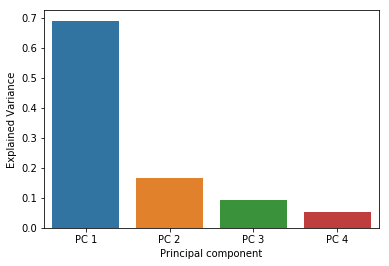

In [13]:
n = 4
names = [f'PC {i}' for i in range(1, n  + 1)]
df = pd.DataFrame({'Principal component':names,'Explained Variance':eigenvalues.ravel()/eigenvalues.sum()})
sns.barplot(x='Principal component',y='Explained Variance',data= df)

# Altogether

Let put all the piece together to get our working implementation.

In [14]:
def pca(X,n_components=2):

    #standadize
    mu = X.mean(axis=0)
    sigma = X.std(axis=0).mean()
    X= (X - mu) / sigma

    # calculate eigen vectors and values
    eigenvectors, eigenvalues, _ = np.linalg.svd(X.T, full_matrices=False)

    #Sort eigen vectors by size of eigen value
    eigenpairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvectors))]
    eigenpairs.sort(reverse=True)

    #Reorganize eigen vectors by eigen values
    n_components = len(eigenvectors)
    eigenvectors = np.vstack([eigenpairs[i][1] for i in range(n)])
    eigenvalues = np.vstack([eigenpairs[i][0] for i in range(n)])

    k = 2
    return X @ eigenvectors, eigenvectors, eigenvalues

# Sklearn
Just for sanity lets check our implementation against sklearn.

In [15]:
from sklearn.decomposition import PCA

In [16]:
X_transfromed,eigenvectors,eigenvalues = pca(X)

In [17]:
pca_sk = PCA(2)
pca_sk.fit(X)
X_transformed_sk =  pca_sk.fit_transform(X)

In [18]:
pca_sk.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [19]:
eigenvectors

array([[-0.36138659,  0.08452251, -0.85667061, -0.3582892 ],
       [-0.65658877, -0.73016143,  0.17337266,  0.07548102],
       [ 0.58202985, -0.59791083, -0.07623608, -0.54583143],
       [ 0.31548719, -0.3197231 , -0.47983899,  0.75365743]])

In [22]:
#rounding error means not totally equal
(np.matrix.round(X_transformed,5) ==  np.matrix.round(X_transformed_sk,5))

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


False

# References

* [Eigenvectors and values visually explained](http://setosa.io/ev/eigenvectors-and-eigenvalues/)
* [Understanding Eigenvector and Egienvalues Visually](https://alyssaq.github.io/2015/understanding-eigenvectors-and-eigenvalues-visually/)
* [Plotly PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/)